1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2022-12-02 14:33:04--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2022-12-02 14:33:05--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uced2d0036a0417c6819ec7e57e4.dl.dropboxusercontent.com/cd/0/inline/Bx2CoV6kxkh7Ex8pXJANt3Erb7SrCpX1QjoSkjKRkcp76A0GzMfVICxV8FH4IkgiWOvudC51_HH7pPoko0OK3TzfbMaVbLuEKQf1ttnpe6vhD9bKlgZCIgWg66QKkIgehEmFUIIOGwbwFQ9QqGP9JxiGY900YfYvDaGDJ2d4zdwuUA/file# [following]
--2022-12-02 14:33:05--  https://uced2d0036a0417c6819ec7e57e4.dl.dropboxusercontent.com/cd/0/inline/Bx2CoV6kxkh7Ex8pXJANt3Erb7SrCpX1QjoSkjKRkcp76A0GzMfVICxV8FH4IkgiWOvu

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [3]:
import pandas as pd
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name).iloc[:20000]
data


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [4]:
bx_value = max (data["BX_COUNTER"]) + 1
print("estimated number of BX in orbit: ",bx_value)

estimated number of BX in orbit:  3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [5]:
data["ABS_TIME(ns)"] = data['TDC_MEAS'] *(25 / 30) + data['BX_COUNTER'] * 25 +data['ORBIT_CNT'] * bx_value * 25
data


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME(ns)
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29,3.447458e+14
19996,1,0,63,3869200366,2517,6,3.447458e+14
19997,1,0,32,3869200366,2519,5,3.447458e+14
19998,1,0,17,3869200366,2522,21,3.447458e+14


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [6]:
import datetime as dt

itime = dt.datetime.now()
print("Begin time:", itime)

# the one-liner command
time =  data['TDC_MEAS'] *(25/30) + data['BX_COUNTER'] * 25 + data['ORBIT_CNT']*bx_value*25

ftime = dt.datetime.now()
print("End time:", ftime)
print("Elapsed time:", (ftime - itime))


Begin time: 2022-12-02 14:33:13.477883
End time: 2022-12-02 14:33:13.484849
Elapsed time: 0:00:00.006966


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
ns_channel = data.groupby('TDC_CHANNEL').sum()
ns_channel = ns_channel.sort_values(by=['HEAD'],ascending=False).iloc[:3]
ns_channel


,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME(ns)
TDC_CHANNEL,,,,,,
139,1693,522,6550556050500,2991203,0,5.836545e+17
64,996,21,3853723466506,1834885,14512,3.433668e+17
63,969,8,3749255057021,1753201,14389,3.340586e+17


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).


In [8]:
non_empty_orbits = data.groupby('ORBIT_CNT').size().reset_index(name='counts')
print("non-empty orbits:",len(non_empty_orbits))

non-empty orbits: 200


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [9]:
unique_orbits = data[data['TDC_CHANNEL']==139].groupby('ORBIT_CNT').size().reset_index(name='counts')
print("unique orbits from TDC_channel:",len(unique_orbits))

unique orbits from TDC_channel: 200


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

<AxesSubplot:title={'center':'FPGA 1'}, xlabel='TDC_CHANNEL'>

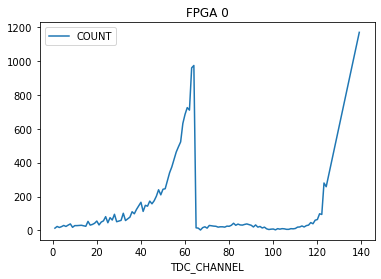

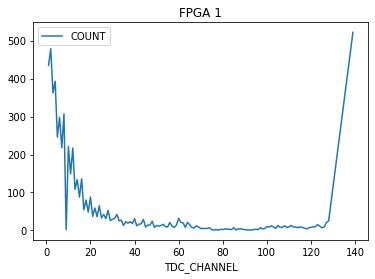

In [10]:
# two series one for each FPGA (0,1)
fpga_0 = data[data['FPGA']== 0].groupby('TDC_CHANNEL').size().reset_index(name='COUNT')
fpga_0.plot(x = 'TDC_CHANNEL', y = 'COUNT', title = "FPGA 0")

fpga_1 = data[data['FPGA']== 1].groupby('TDC_CHANNEL').size().reset_index(name='COUNT')
fpga_1.plot(x = 'TDC_CHANNEL', y = 'COUNT', title = "FPGA 1")

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.